# IMPORTS

In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import warnings
import string
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objs as go
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff
from mlxtend.plotting import plot_confusion_matrix 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
import requests 
from sklearn.decomposition import NMF
from tqdm import tqdm
import collections

# Whisky Dataset

## Load Scotch Whisky Reviews

This dataset comes from Kaggle, but was originally scrapped from Whisky Advocate, a popular whisky website. The data includes 2,247 data points specifically that of Scotch whisky. The data focuses on reviews of these whiskies, or in other words, text descriptions. By examining this text, I plan to use NLP to perform topic modeling, and create a recommendation system for Scotch Whisky.

In [33]:
review = pd.read_csv("scotch_review.csv")
review.rename(columns={'Unnamed: 0':'ID'},inplace=True)

In [34]:
review

,ID,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."
...,...,...,...,...,...,...,...
2242,2243,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72,125.00,$,"Its best attributes are vanilla, toasted cocon..."
2243,2244,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71,60.00,$,"Aged in a sherry cask, which adds sweet notes ..."
2244,2245,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70,80.00,$,"Earthy, fleshy notes with brooding grape notes..."
2245,2246,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70,225.00,$,"The sherry is very dominant and cloying, which..."


In [35]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            2247 non-null   int64 
 1   name          2247 non-null   object
 2   category      2247 non-null   object
 3   review.point  2247 non-null   int64 
 4   price         2247 non-null   object
 5   currency      2247 non-null   object
 6   description   2247 non-null   object
dtypes: int64(2), object(5)
memory usage: 123.0+ KB


# Exploratory Data Analzsis

## Existing Attributes

### A. Price

In [36]:
# Notice the price coloumn isn't a number, need to convert
# Find out what we need toremove 
review.price.loc[~review.price.str.match('^[\d]+[\.]*[\d]*$')]

19      $15,000 or $60,000/set
49                      30,000
95                  60,000/set
100                      1,700
102                      1,100
109                     60,000
140                      3,500
147                      4,000
191                      1,100
197                      7,500
301                      1,735
308                      1,100
410                 60,000/set
437                      7,500
576                   44/liter
608                   1,500.00
924                      1,400
1000                60,000/set
1215                60,000/set
Name: price, dtype: object

In [37]:
# Change price from string to float
# Instances with '60,000/set' ==  15000 dollars
# Rows with issues: 19,95,410,1000 and 1215
review.at[[19, 95, 410, 1000, 1215], 'price'] = 15000  
# These bottles were 1 liter so we don't need price per liter 
review['price'].replace('/liter', '', inplace = True, regex = True) 
#Remove commas
review['price'].replace(',', '', inplace = True, regex = True)
#Set price to a float
review['price'] = review['price'].astype('float')
review['price'] = review['price'].astype('int')

### B. Currency

In [38]:
# Count how many currencies we have
review['currency'].value_counts()
# Only $, useless remove it
review.drop('currency', axis = 1, inplace = True)

## New Attributes

We have removed the column 'currency' since it was not informative. Now, we have created these new attributes from information given in the name of the whisky.

### Age and Alcohol% per whisky type

In [39]:
# Extract age and convert to float
review['age'] = review['name'].str.extract(r'(\d+) year')[0].astype(float) 
review['name'] = review['name'].str.replace(' ABV ', '')
review['alcohol%'] = review['name'].str.extract(r"([\(\,\,\'\"\’\”\$] ? ?\d+(\.\d+)?%)")[0]
# Keep only numbers and convert to float
review['alcohol%'] = review['alcohol%'].str.replace("[^\d\.]", "").astype(float)

In [40]:
# Check for missing values
review[['age', 'alcohol%']].isnull().sum()

age         1033
alcohol%      17
dtype: int64

In [41]:
review

,ID,name,category,review.point,price,description,age,alcohol%
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ...",NaN,40.0
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500,What impresses me most is how this whisky evol...,42.0,40.5
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,There have been some legendary Bowmores from t...,46.0,42.9
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin...",NaN,40.0
...,...,...,...,...,...,...,...,...
2242,2243,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72,125,"Its best attributes are vanilla, toasted cocon...",28.0,54.4
2243,2244,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71,60,"Aged in a sherry cask, which adds sweet notes ...",8.0,45.0
2244,2245,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70,80,"Earthy, fleshy notes with brooding grape notes...",11.0,57.1
2245,2246,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70,225,"The sherry is very dominant and cloying, which...",25.0,55.0


In [42]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2247 non-null   int64  
 1   name          2247 non-null   object 
 2   category      2247 non-null   object 
 3   review.point  2247 non-null   int64  
 4   price         2247 non-null   int64  
 5   description   2247 non-null   object 
 6   age           1214 non-null   float64
 7   alcohol%      2230 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 140.6+ KB


# EDA Visualization: Plotly
### Gaining insights and drawing conclusions

## Whisky Category vs. Count

In [43]:
import plotly.express as px

In [22]:
# Data is very heavily Single Malt Scotch (imbalanced, more than 80% of all whiskies)
dataframe_count=review.groupby(['category']).size().sort_values(ascending=True).reset_index(name="Count")
dataframe_count['Count']=dataframe_count['Count']/sum(dataframe_count['Count'])
fig = go.Figure(
    data=[
    go.Bar(x=dataframe_count.category, y=dataframe_count.Count),
])
fig.update_layout(
    title_text='Number of Bottles per Category', 
    title_x=0.45,
    xaxis_title="Category of Whisky",
    yaxis_title="Count of each Category",
)
fig.update_layout(yaxis_tickformat = '%')
fig.show() 

## Distribution of Review Points

In [111]:
print("The range of the points is",review['review.point'].min(),"-",review['review.point'].max())
x = review['review.point']
group_labels = 'Distribution of Review Points'
fig = ff.create_distplot([x], [group_labels], bin_size=.5, show_rug=False)
fig.update_layout(width=600, 
                  height=400,
                  bargap=0.1)

The range of the points is 63 - 97


## Distribution of Price

In [24]:
fig = px.histogram(review, x="price")
fig.update_xaxes(range=[0, 30000])
fig.show()

## Distribution of Age

In [44]:
fig = px.histogram(review, x="age").update_xaxes(categoryorder="total ascending")
fig.show()

## Distribution of Alcohol %

In [45]:
fig = px.histogram(review, x="alcohol%").update_xaxes(categoryorder="total ascending")
fig.show()

## Average  Review Points per Category
### Including Outliers

In [46]:
# Observe that he median points have a small range of values: 
# from 86 (Single Grain) to 88 (Blended Malts)
# Reviews are very similar across the board (similar medians)
y0 = review[review.category=="Single Malt Scotch"]['review.point'].values
y1 = review[review.category=="Blended Scotch Whisky"]['review.point'].values
y2 = review[review.category=="Blended Malt Scotch Whisky"]['review.point'].values
y3 = review[review.category=="Single Grain Whisky"]['review.point'].values
y3 = review[review.category=="Single Grain Whisky"]['review.point'].values
y4 = review[review.category=="Grain Scotch Whisky"]['review.point'].values
fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Single Malt Scotch',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y1, name = 'Blended Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y2, name = 'Blended Malt Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y3, name = 'Single Grain Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y4, name = 'Grain Scotch Whisky',marker_color = 'royalblue'))
fig.show()

In [47]:
y0 = review[review.category=="Single Malt Scotch"]['review.point'].median()
y1 = review[review.category=="Blended Scotch Whisky"]['review.point'].median()
y2 = review[review.category=="Blended Malt Scotch Whisky"]['review.point'].median()
y3 = review[review.category=="Single Grain Whisky"]['review.point'].median()
y4 = review[review.category=="Grain Scotch Whisky"]['review.point'].median()
x=["Single Malt Scotch","Blended Scotch Whisky","Blended Malt Scotch Whisky","Single Grain Whisky","Grain Scotch Whisky"]
y=[y0,y1,y2,y3,y4]
fig = px.line( x = x ,y = y,title = 'Median Review Points')
fig.show()

## Distribution of Price per Category
### Including outliers

In [48]:
# The scale of this graph is hard to interpret, but useful to find outliers
# Also note Single Malt is highest
y0 = review[review.category=="Single Malt Scotch"]['price'].values
y1 = review[review.category=="Blended Scotch Whisky"]['price'].values
y2 = review[review.category=="Blended Malt Scotch Whisky"]['price'].values
y3 = review[review.category=="Single Grain Whisky"]['price'].values
y4 = review[review.category=="Grain Scotch Whisky"]['price'].values
fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Single Malt Scotch',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y1, name = 'Blended Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y2, name = 'Blended Malt Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y3, name = 'Single Grain Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y4, name = 'Grain Scotch Whisky',marker_color = 'royalblue'))
fig.show()

## Mean Price per Category

In [49]:
# On average blended scotsh whisky has higher price
# While Blended Malt Scotch Whisky, Single Grain Whisky, and Grain Scotch Whiskey are relatively similar
y1=review[review.category=="Single Malt Scotch"]['price'].mean()
y2=review[review.category=="Blended Scotch Whisky"]['price'].mean()
y3=review[review.category=="Blended Malt Scotch Whisky"]['price'].mean()
y4=review[review.category=="Single Grain Whisky"]['price'].mean()
y5=review[review.category=="Grain Scotch Whisky"]['price'].mean()
x=["Single Malt Scotch","Blended Scotch Whisky","Blended Malt Scotch Whisky","Single Grain Whisky","Grain Scotch Whisky"]
y=[y1,y2,y3,y4,y5]
fig = go.Figure(
    data=[go.Bar( x=x,y=y),
])
fig.update_layout(
    title_text='Average Price per Bottle per Category', 
    title_x=0.45,
    xaxis_title="Category of Whisky",
    yaxis_title="Average Price",
)
fig.update_layout(yaxis_tickprefix = '$')
fig.show() 

## Mean Review Point per Category

In [50]:
# On average, Blended Malt whiskies score highest
y1=review[review.category=="Single Malt Scotch"]['review.point'].mean()
y2=review[review.category=="Blended Scotch Whisky"]['review.point'].mean()
y3=review[review.category=="Blended Malt Scotch Whisky"]['review.point'].mean()
y4=review[review.category=="Single Grain Whisky"]['review.point'].mean()
y5=review[review.category=="Grain Scotch Whisky"]['review.point'].mean()
x=["Single Malt Scotch","Blended Scotch Whisky","Blended Malt Scotch Whisky","Single Grain Whisky","Grain Scotch Whisky"]
y=[y1,y2,y3,y4,y5]
fig = go.Figure(
    data=[go.Bar( x=x,y=y),
])
fig.update_layout(
    title_text='Average Point per Bottle per Category', 
    title_x=0.45,
    xaxis_title="Category of Whisky",
    yaxis_title="Average Points",
)
fig.update_layout(yaxis_range=[80,90])
fig.show() 

## Mean Age per Category

In [51]:
# Single Grain and Grain whiskies are the oldest
y1=review[review.category=="Single Malt Scotch"]['age'].mean()
y2=review[review.category=="Blended Scotch Whisky"]['age'].mean()
y3=review[review.category=="Blended Malt Scotch Whisky"]['age'].mean()
y4=review[review.category=="Single Grain Whisky"]['age'].mean()
y5=review[review.category=="Grain Scotch Whisky"]['age'].mean()
x=["Single Malt Scotch","Blended Scotch Whisky","Blended Malt Scotch Whisky","Single Grain Whisky","Grain Scotch Whisky"]
y=[y1,y2,y3,y4,y5]
fig = go.Figure(
    data=[go.Bar( x=x,y=y),
])
fig.update_layout(
    title_text='Average Age per Bottle per Category', 
    title_x=0.45,
    xaxis_title="Category of Whisky",
    yaxis_title="Age",
)
fig.show() 

## Mean Alcohol% per Category

In [108]:
# Single Grain and Grain whiskies are the most alchoholic bottles 
y1=review[review.category=="Single Malt Scotch"]['alcohol%'].mean()
y2=review[review.category=="Blended Scotch Whisky"]['alcohol%'].mean()
y3=review[review.category=="Blended Malt Scotch Whisky"]['alcohol%'].mean()
y4=review[review.category=="Single Grain Whisky"]['alcohol%'].mean()
y5=review[review.category=="Grain Scotch Whisky"]['alcohol%'].mean()
x=["Single Malt Scotch","Blended Scotch Whisky","Blended Malt Scotch Whisky","Single Grain Whisky","Grain Scotch Whisky"]
y=[y1,y2,y3,y4,y5]
fig = go.Figure(
    data=[go.Bar( x=x,y=y),
])
fig.update_layout(
    title_text='Average Alcohol% per Bottle per Category', 
    title_x=0.45,
    xaxis_title="Category of Whisky",
    yaxis_title="Age",
)
fig.show() 

## Column Descriptions:
### WordClouds and Bar Graphs 

These are images used to display the frequency of words in each of the 5 whisky categories.

In [55]:
# Create a function that displays wordclouds for each of our categories
# Including basic stop words for now, more to add
def create_word_cloud(df, bg_color, max_words, mask, stop_words, max_font_size, colormap):
    wc = WordCloud(background_color = bg_color, max_words = max_words, mask = mask,stopwords = stop_words, max_font_size = max_font_size)
    wc.generate(' '.join(df))
    return wc.recolor(colormap = colormap, random_state = 42)

In [56]:
SM_df = review[review['category'] == 'Single Malt Scotch']['description'].values
BD_df = review[review['category'] == 'Blended Scotch Whisky']['description'].values
BMS_df = review[review['category'] == 'Blended Malt Scotch Whisky']['description'].values
SG_df = review[review['category'] == 'Single Grain Whisky']['description'].values
GS_df = review[review['category'] == 'Grain Scotch Whisky']['description'].values
# Mask to shape into a bottle image!
word_cloud_mask = np.array(Image.open(requests.get('https://imgur.com/upL1TBW.png', stream = True).raw)) 
#List of stopwords that we don't want to be displayed
stop_words = list(STOPWORDS)

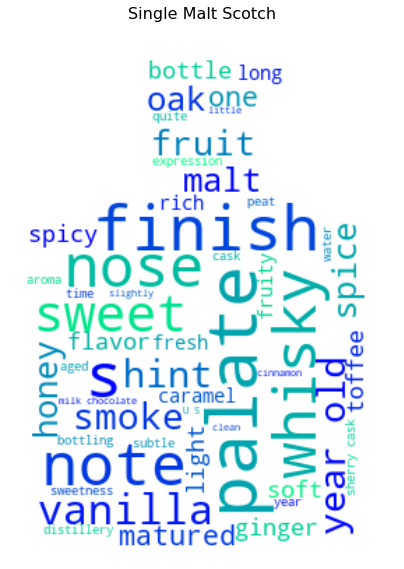

In [57]:
fig, ax = plt.subplots(figsize = (7, 14))
ax.imshow(create_word_cloud(df = SM_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Single Malt Scotch', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('foo.png')

(-0.5, 279.5, 369.5, -0.5)

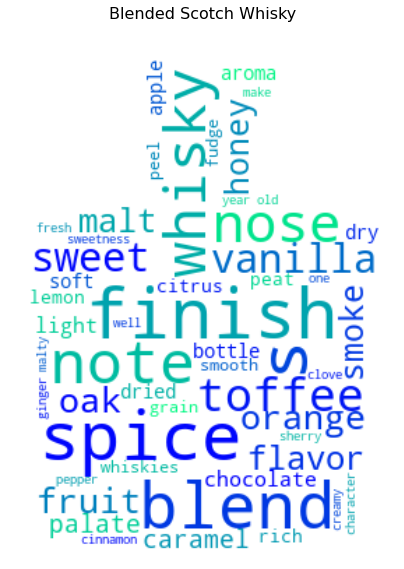

In [58]:
fig, ax = plt.subplots(figsize = (7, 14)) 
ax.imshow(create_word_cloud(df = BD_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Blended Scotch Whisky', size = 16, y = 1.04)
ax.axis('off')

In [59]:
# See very useless words right off the bat, need ot begin a stop lis
# Add extra stop words that are useless and aren't necessary
stop_words = ['whisky', 'whiskies', 'blend', 'note', 'notes', 'year', 'years', 'old', 'nose', 'finish', 'bottle',
              'bottles', 'bottled', 'along', 'release', 'flavor', 'cask', 'well', 'make', 'mouth', 'palate', 'hint',
              'one', 'bottling', 'distillery', 'quite', 'time', 'date', 'show', 'first'] + list(STOPWORDS)

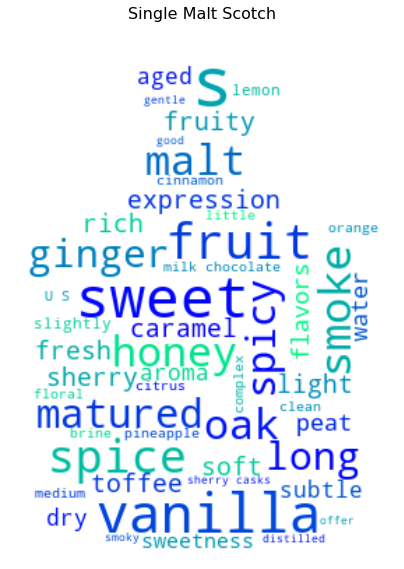

In [60]:
fig, ax = plt.subplots(figsize = (7, 14)) 
ax.imshow(create_word_cloud(df = SM_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Single Malt Scotch', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('Signle_Malt_Scotch.png')

In [61]:
to_print=20
listToStr = ' '.join([str(elem) for elem in SM_df])

{'grain': 23, 'light': 12, 'vanilla,': 10, 'spice': 7, 'sweet': 7, 'pepper': 7, 'finish.': 7, 'dry': 7, 'peel,': 7, 'honey,': 6, 'oak': 6, 'vanilla': 6, 'flavors': 6, 'fruit': 6, 'chocolate': 6, 'rather': 6, 'lemon': 6, 'notes,': 6, 'chocolate,': 6, 'bottles)': 5}


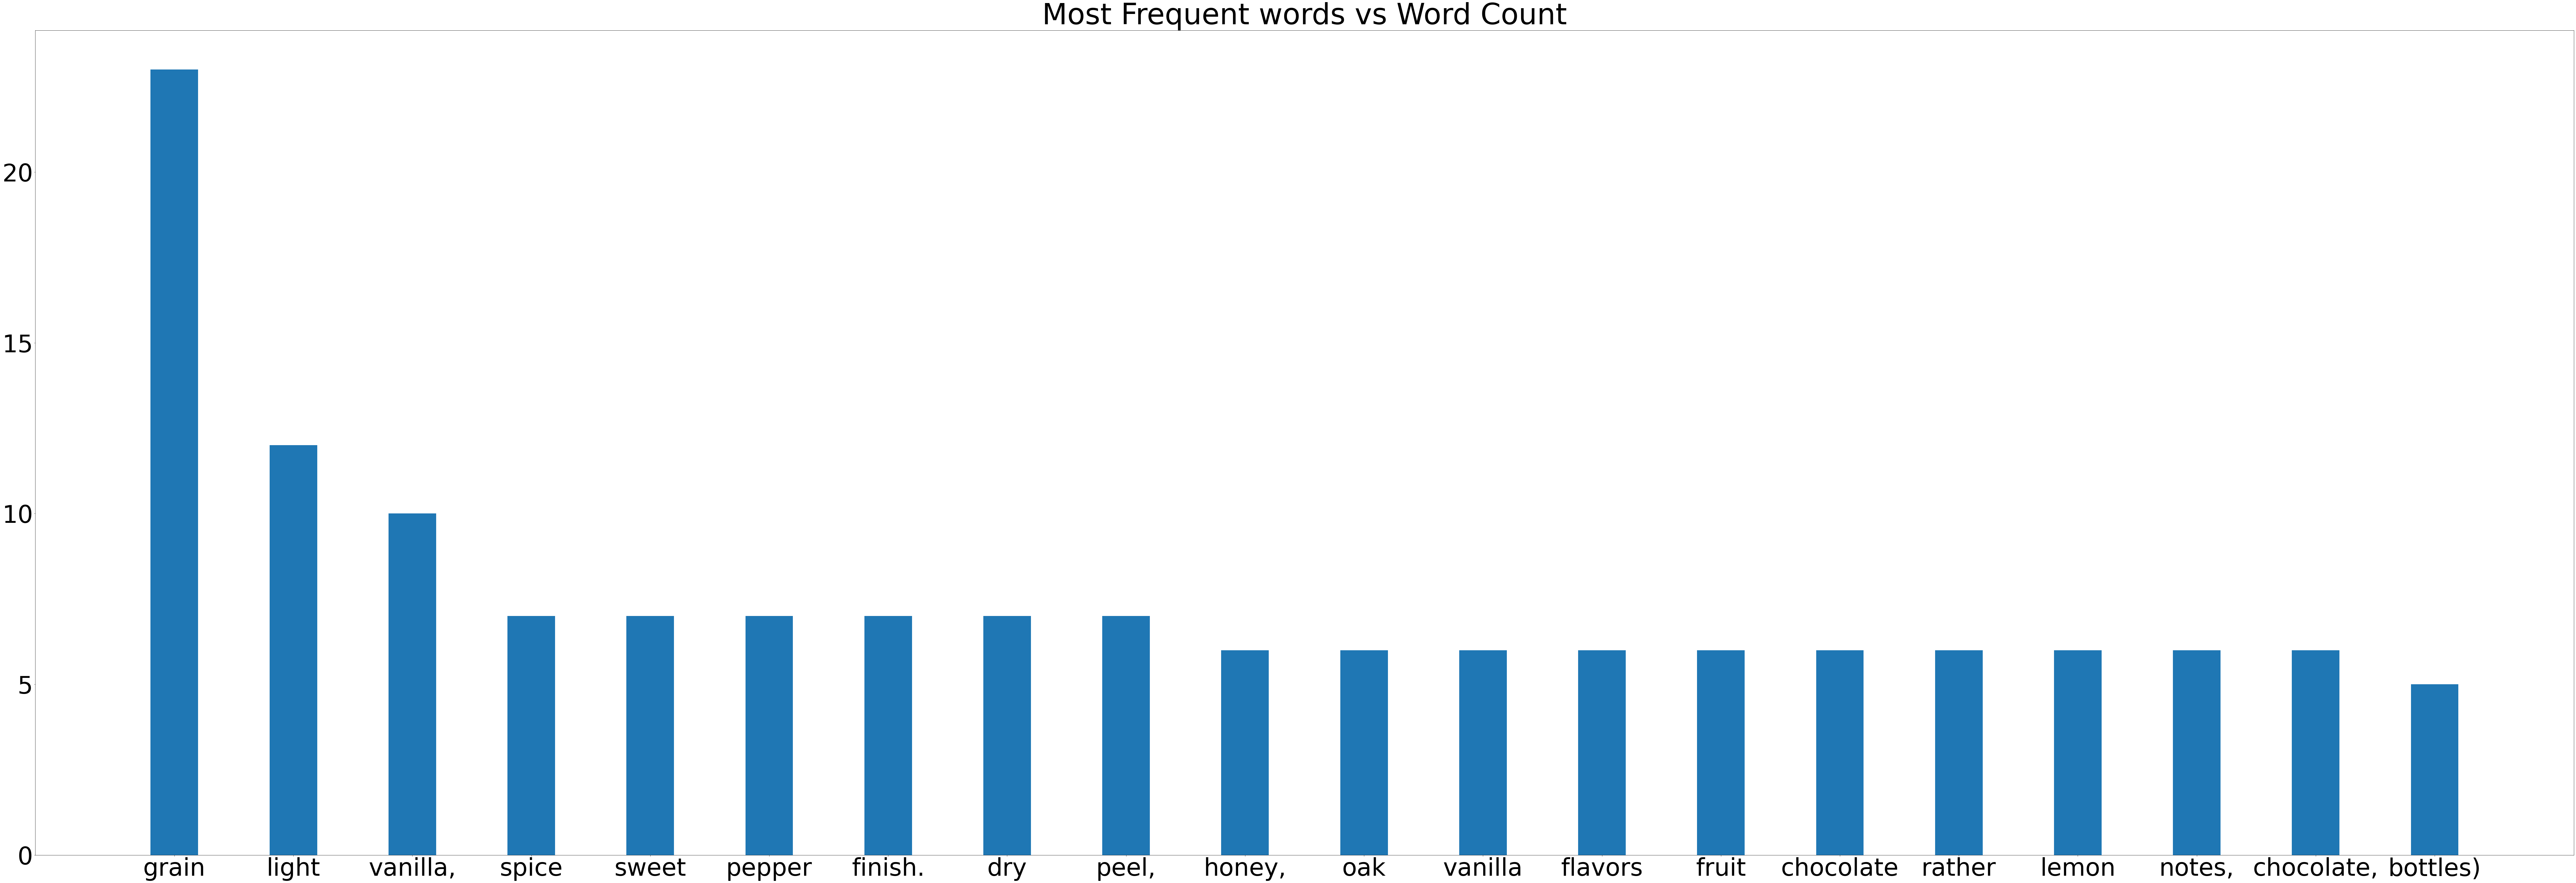

In [82]:
# Write a function to find most frequent words
import collections
stopwords = stop_words
counter=0
Number_of_words=[]
Category=[]
# Find top 10 most frequent words 
wordcount = collections.defaultdict(int)
for word in listToStr.lower().split():
  
    if word not in stopwords:
        wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
plt.rcParams["figure.figsize"] = (150,50)
plt.rcParams.update({'font.size': 80})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent words vs Word Count")
plt.show()
 

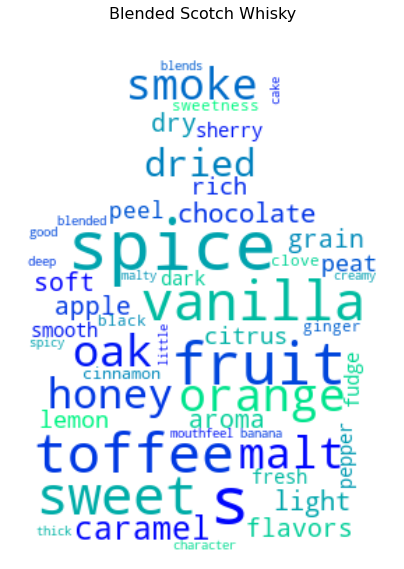

In [85]:
fig, ax = plt.subplots(figsize = (7, 14)) 
ax.imshow(create_word_cloud(df = BD_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Blended Scotch Whisky', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('Blended_Scotch_Whiskey.png')

In [86]:
to_print=20
listToStr = ' '.join([str(elem) for elem in SG_df])

{'bottles)': 30, 'grain': 30, 'sweet': 28, 'vanilla': 21, 'orange': 19, 'it’s': 17, 'flavors': 16, 'apple': 15, 'finish.': 15, 'fresh': 13, 'water': 13, 'vanilla,': 13, 'dried': 12, 'refill': 11, 'oak': 11, 'single': 10, 'green': 10, 'white': 10, 'soft': 9, 'honey,': 9}


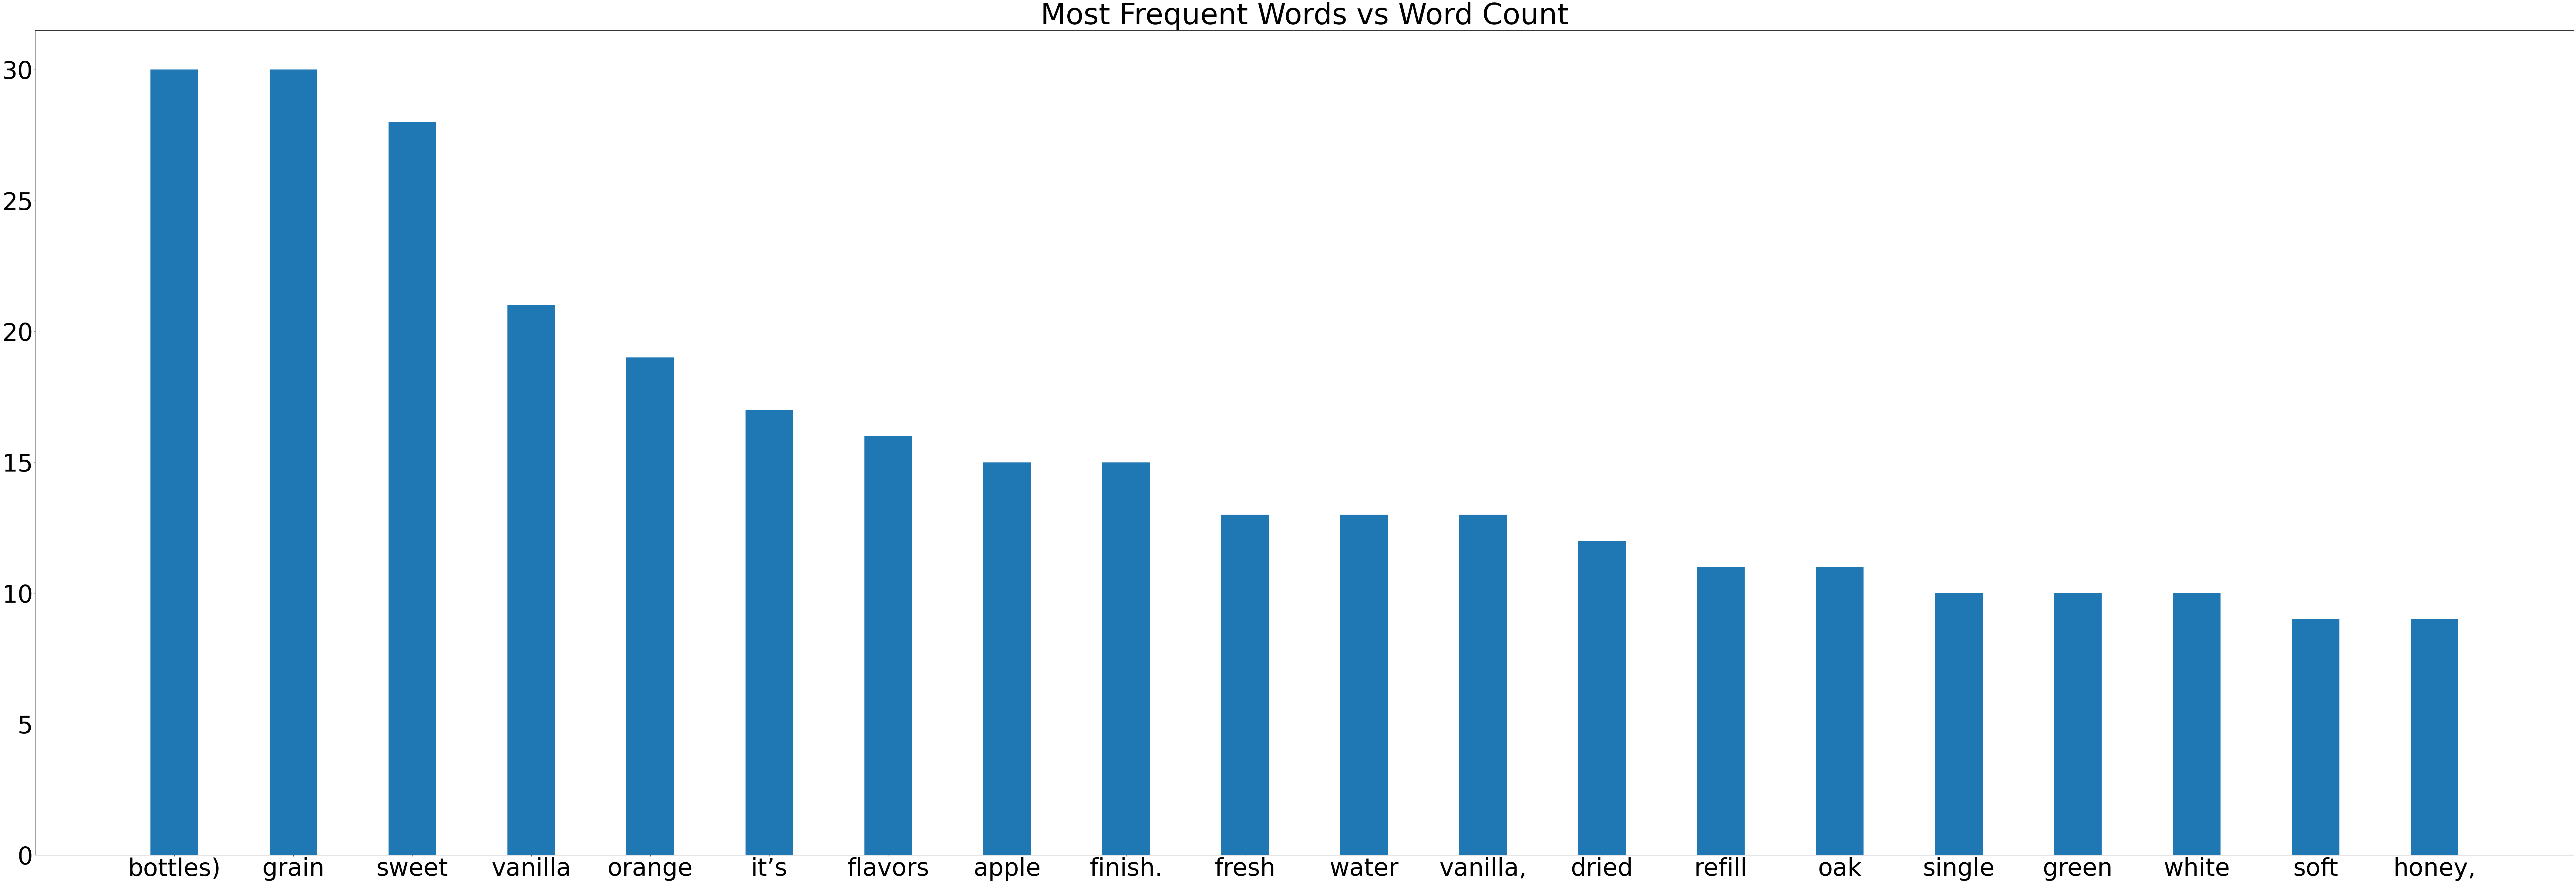

In [87]:
# Write a function to find most frequent words
import collections
stopwords = stop_words
counter=0
Number_of_words=[]
Category=[]
# Find top 10 most frequent words 
wordcount = collections.defaultdict(int)
for word in listToStr.lower().split():
  
    if word not in stopwords:
        wordcount[word] += 1
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
plt.rcParams["figure.figsize"] = (150,50)
plt.rcParams.update({'font.size': 80})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent Words vs Word Count")
plt.show()

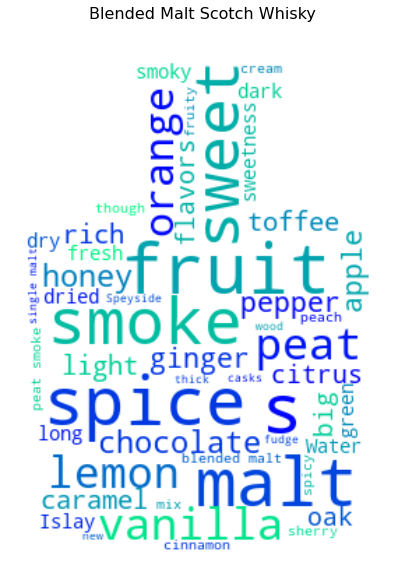

In [88]:
fig, ax = plt.subplots(figsize = (7, 14))
ax.imshow(create_word_cloud(df = BMS_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Blended Malt Scotch Whisky', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('Blended_Malt_Scotch_Whiskey.png')

In [89]:
to_print=20
listToStr = ' '.join([str(elem) for elem in BMS_df])

{'grain': 23, 'light': 12, 'vanilla,': 10, 'spice': 7, 'sweet': 7, 'pepper': 7, 'finish.': 7, 'dry': 7, 'peel,': 7, 'honey,': 6, 'oak': 6, 'vanilla': 6, 'flavors': 6, 'fruit': 6, 'chocolate': 6, 'rather': 6, 'lemon': 6, 'notes,': 6, 'chocolate,': 6, 'bottles)': 5}


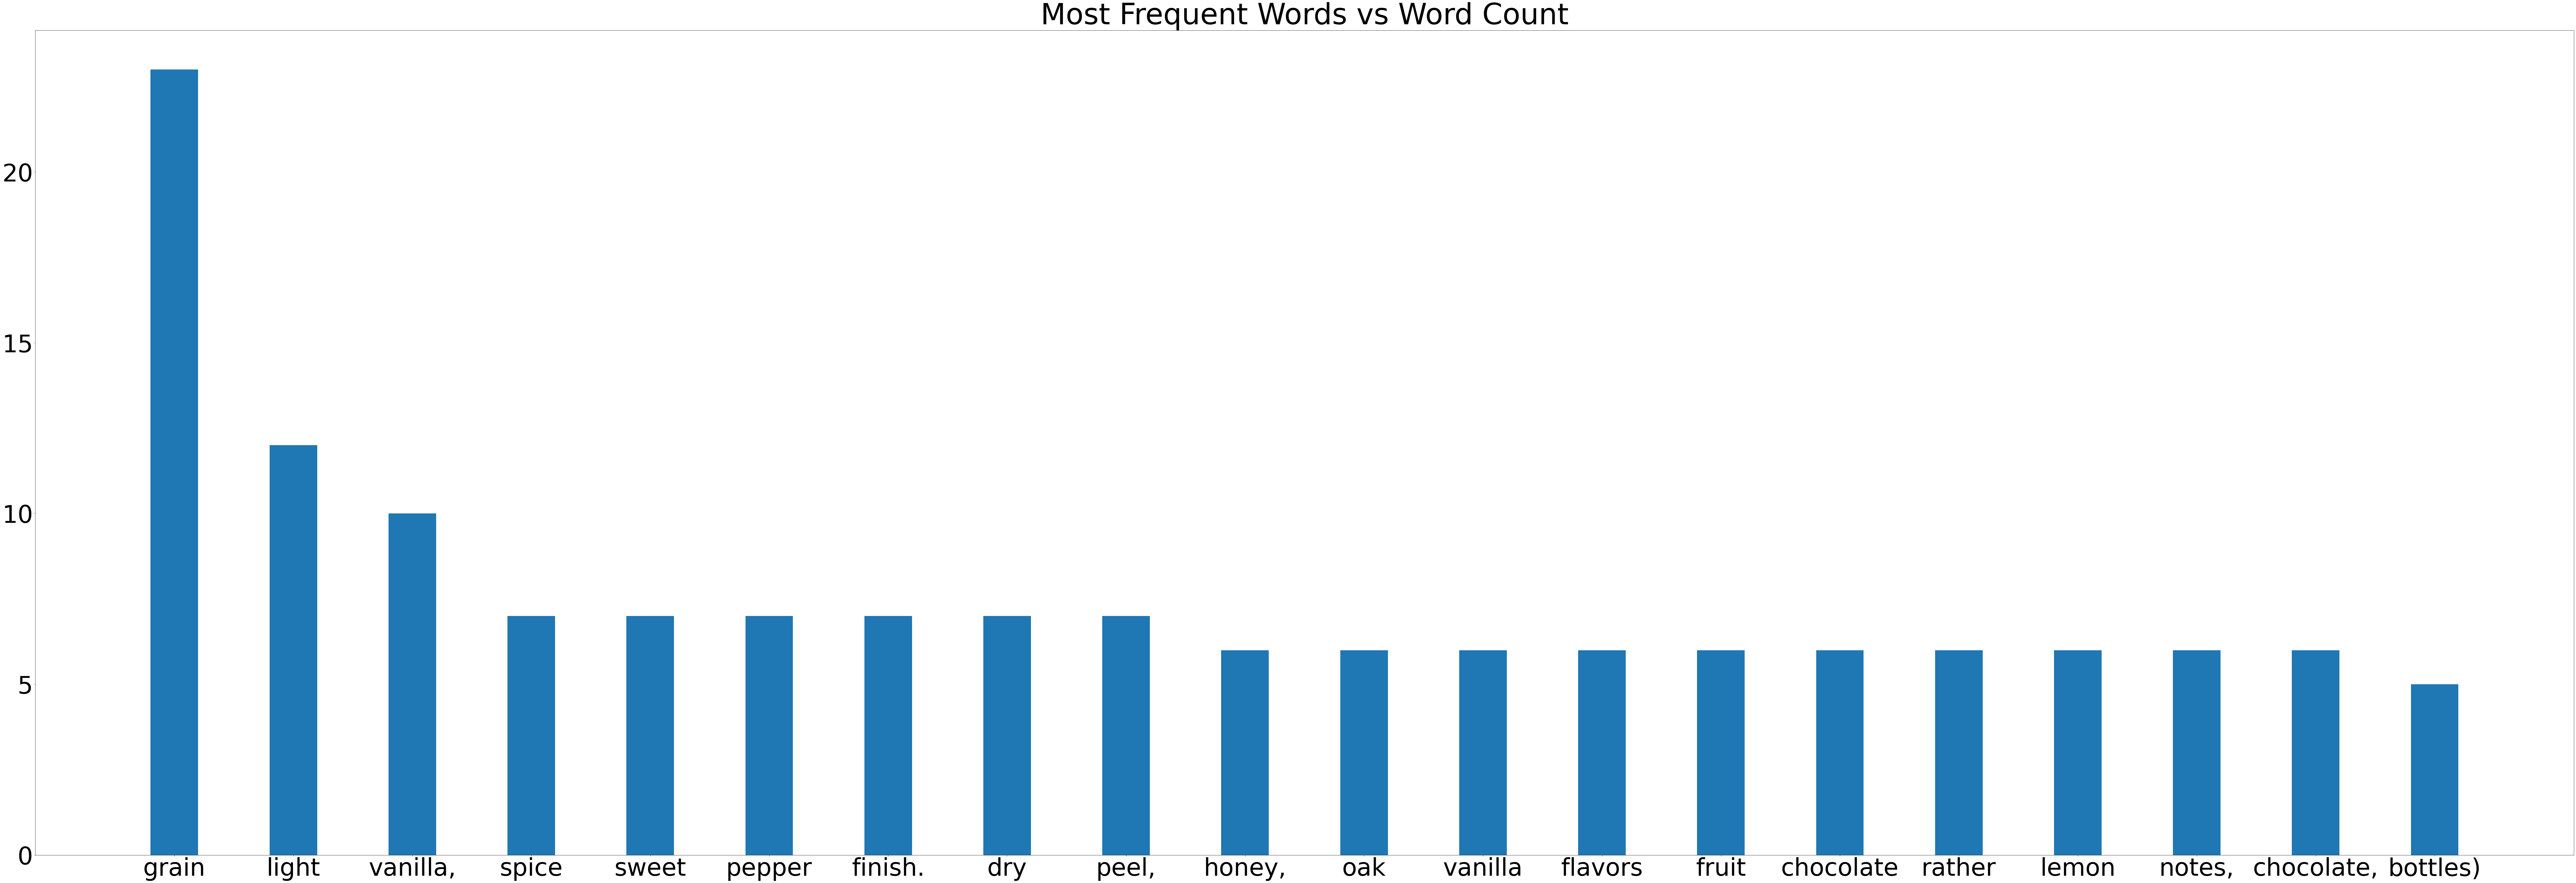

In [101]:
# Write a function to find most frequent words
import collections
stopwords = stop_words
counter=0
Number_of_words=[]
Category=[]
# Find top 10 most frequent words 
wordcount = collections.defaultdict(int)
for word in listToStr.lower().split():
   
    if word not in stopwords:
        wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
plt.rcParams["figure.figsize"] = (150,50)
plt.rcParams.update({'font.size': 80})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent Words vs Word Count")
plt.show()

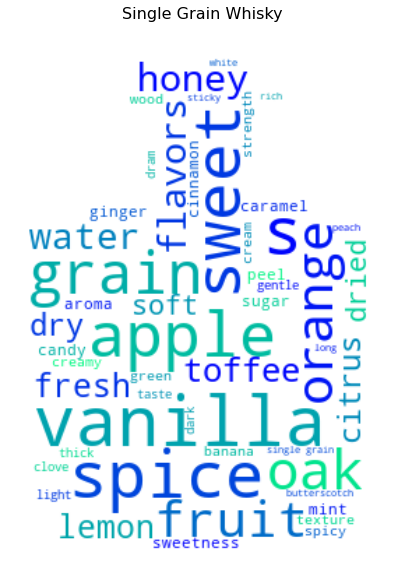

In [91]:
fig, ax = plt.subplots(figsize = (7, 14)) 
ax.imshow(create_word_cloud(df = SG_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Single Grain Whisky', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('Single_Grain_Whiskey.png')

In [92]:
to_print=20
listToStr = ' '.join([str(elem) for elem in SG_df])

{'grain': 23, 'light': 12, 'vanilla,': 10, 'spice': 7, 'sweet': 7, 'pepper': 7, 'finish.': 7, 'dry': 7, 'peel,': 7, 'honey,': 6, 'oak': 6, 'vanilla': 6, 'flavors': 6, 'fruit': 6, 'chocolate': 6, 'rather': 6, 'lemon': 6, 'notes,': 6, 'chocolate,': 6, 'bottles)': 5}


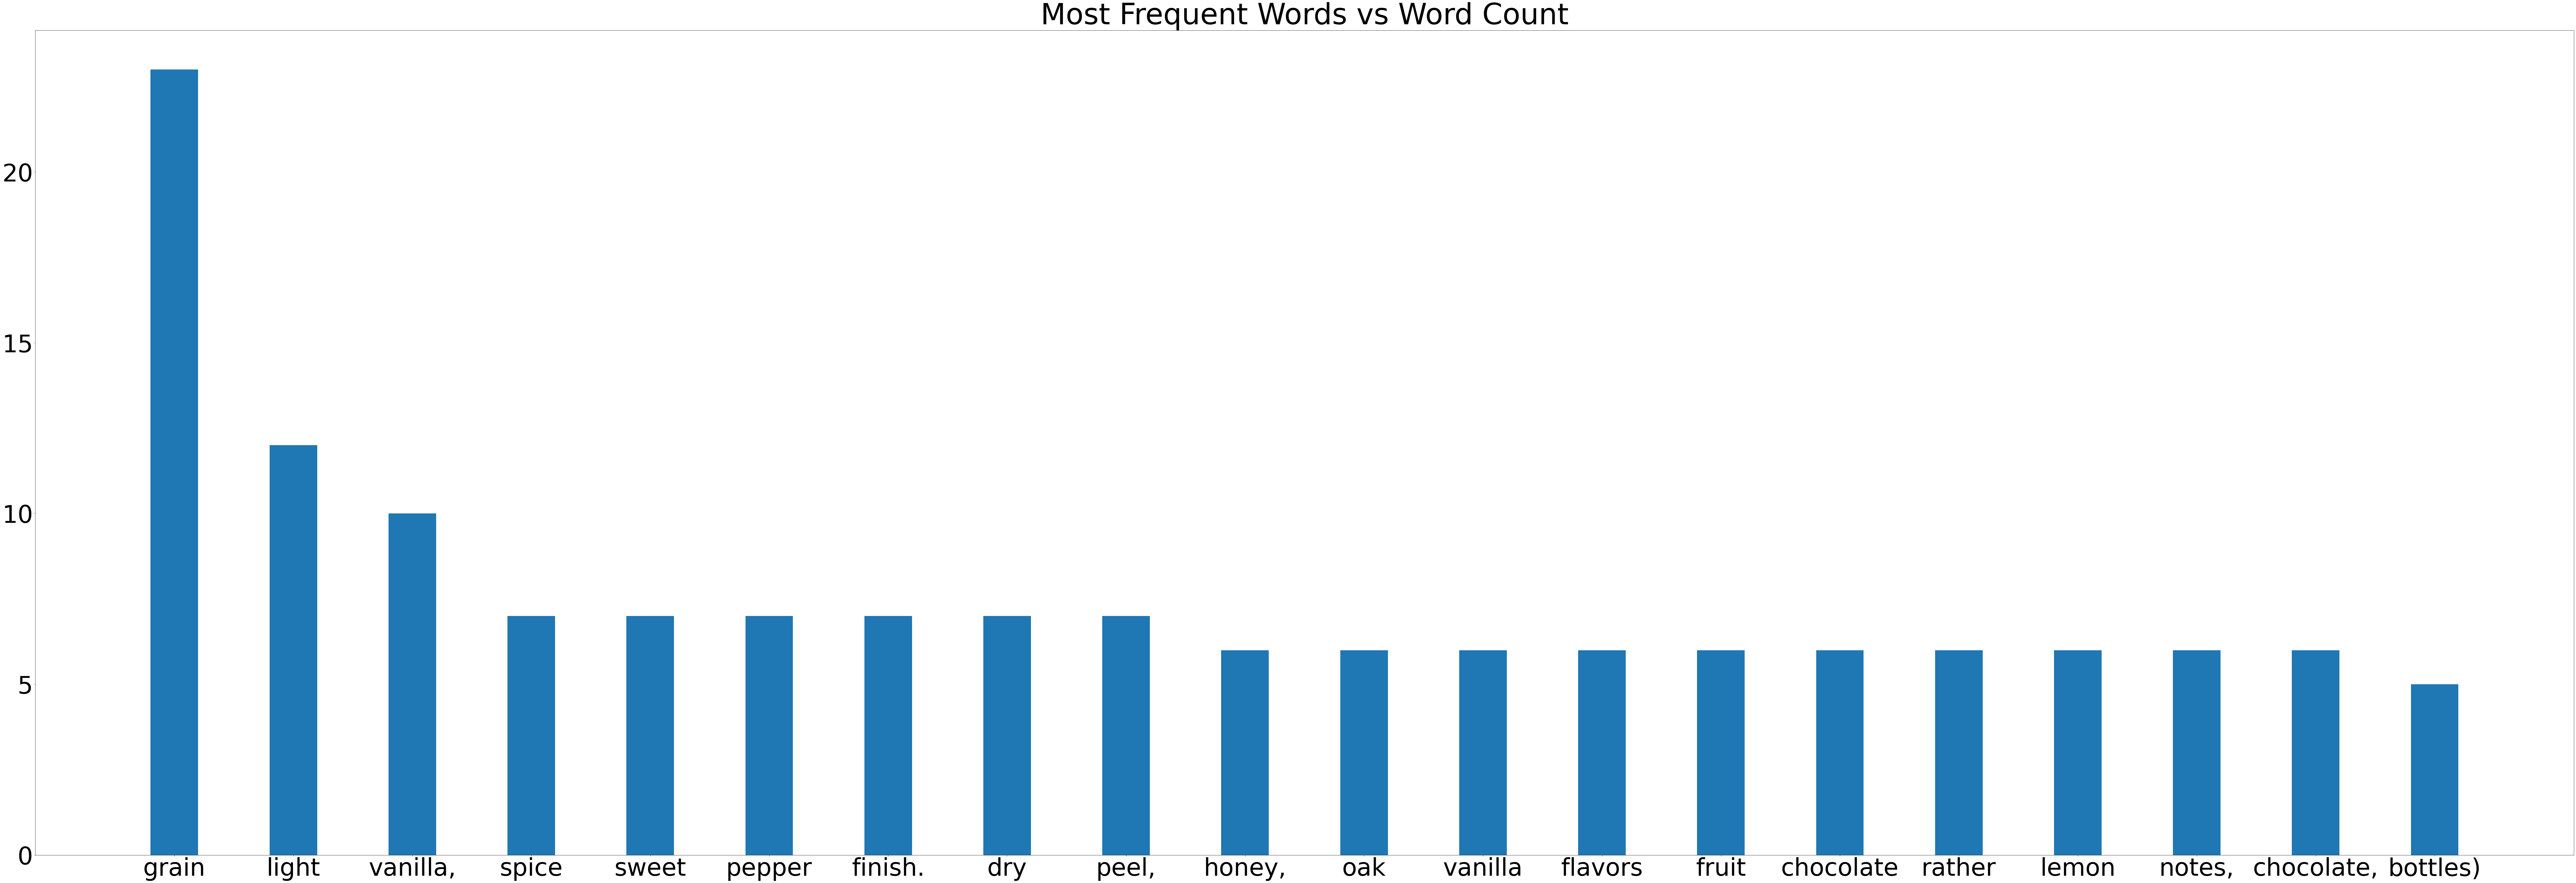

In [100]:
# Write a function to find most frequent words
import collections
stopwords = stop_words
counter=0
Number_of_words=[]
Category=[]
# Find top 10 most frequent words 
wordcount = collections.defaultdict(int)
for word in listToStr.lower().split():
   
    if word not in stopwords:
        wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
plt.rcParams["figure.figsize"] = (150,50)
plt.rcParams.update({'font.size': 80})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent Words vs Word Count")
plt.show()

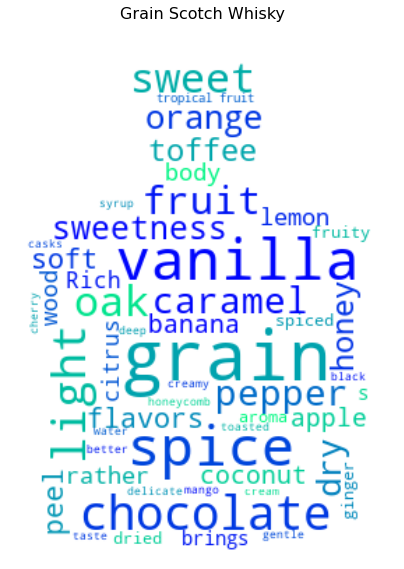

In [97]:
fig, ax = plt.subplots(figsize = (7, 14)) 
ax.imshow(create_word_cloud(df = GS_df, bg_color = 'white', max_words = 50, mask = word_cloud_mask, stop_words = stop_words,
                             max_font_size = 50, colormap = 'winter'), alpha = 1, interpolation = 'bilinear')
ax.set_title('Grain Scotch Whisky', size = 16, y = 1.04)
ax.axis('off')
plt.savefig('Grain_Scotch_Whiskey.png')

In [98]:
to_print=20
listToStr = ' '.join([str(elem) for elem in GS_df])

{'grain': 23, 'light': 12, 'vanilla,': 10, 'spice': 7, 'sweet': 7, 'pepper': 7, 'finish.': 7, 'dry': 7, 'peel,': 7, 'honey,': 6, 'oak': 6, 'vanilla': 6, 'flavors': 6, 'fruit': 6, 'chocolate': 6, 'rather': 6, 'lemon': 6, 'notes,': 6, 'chocolate,': 6, 'bottles)': 5}


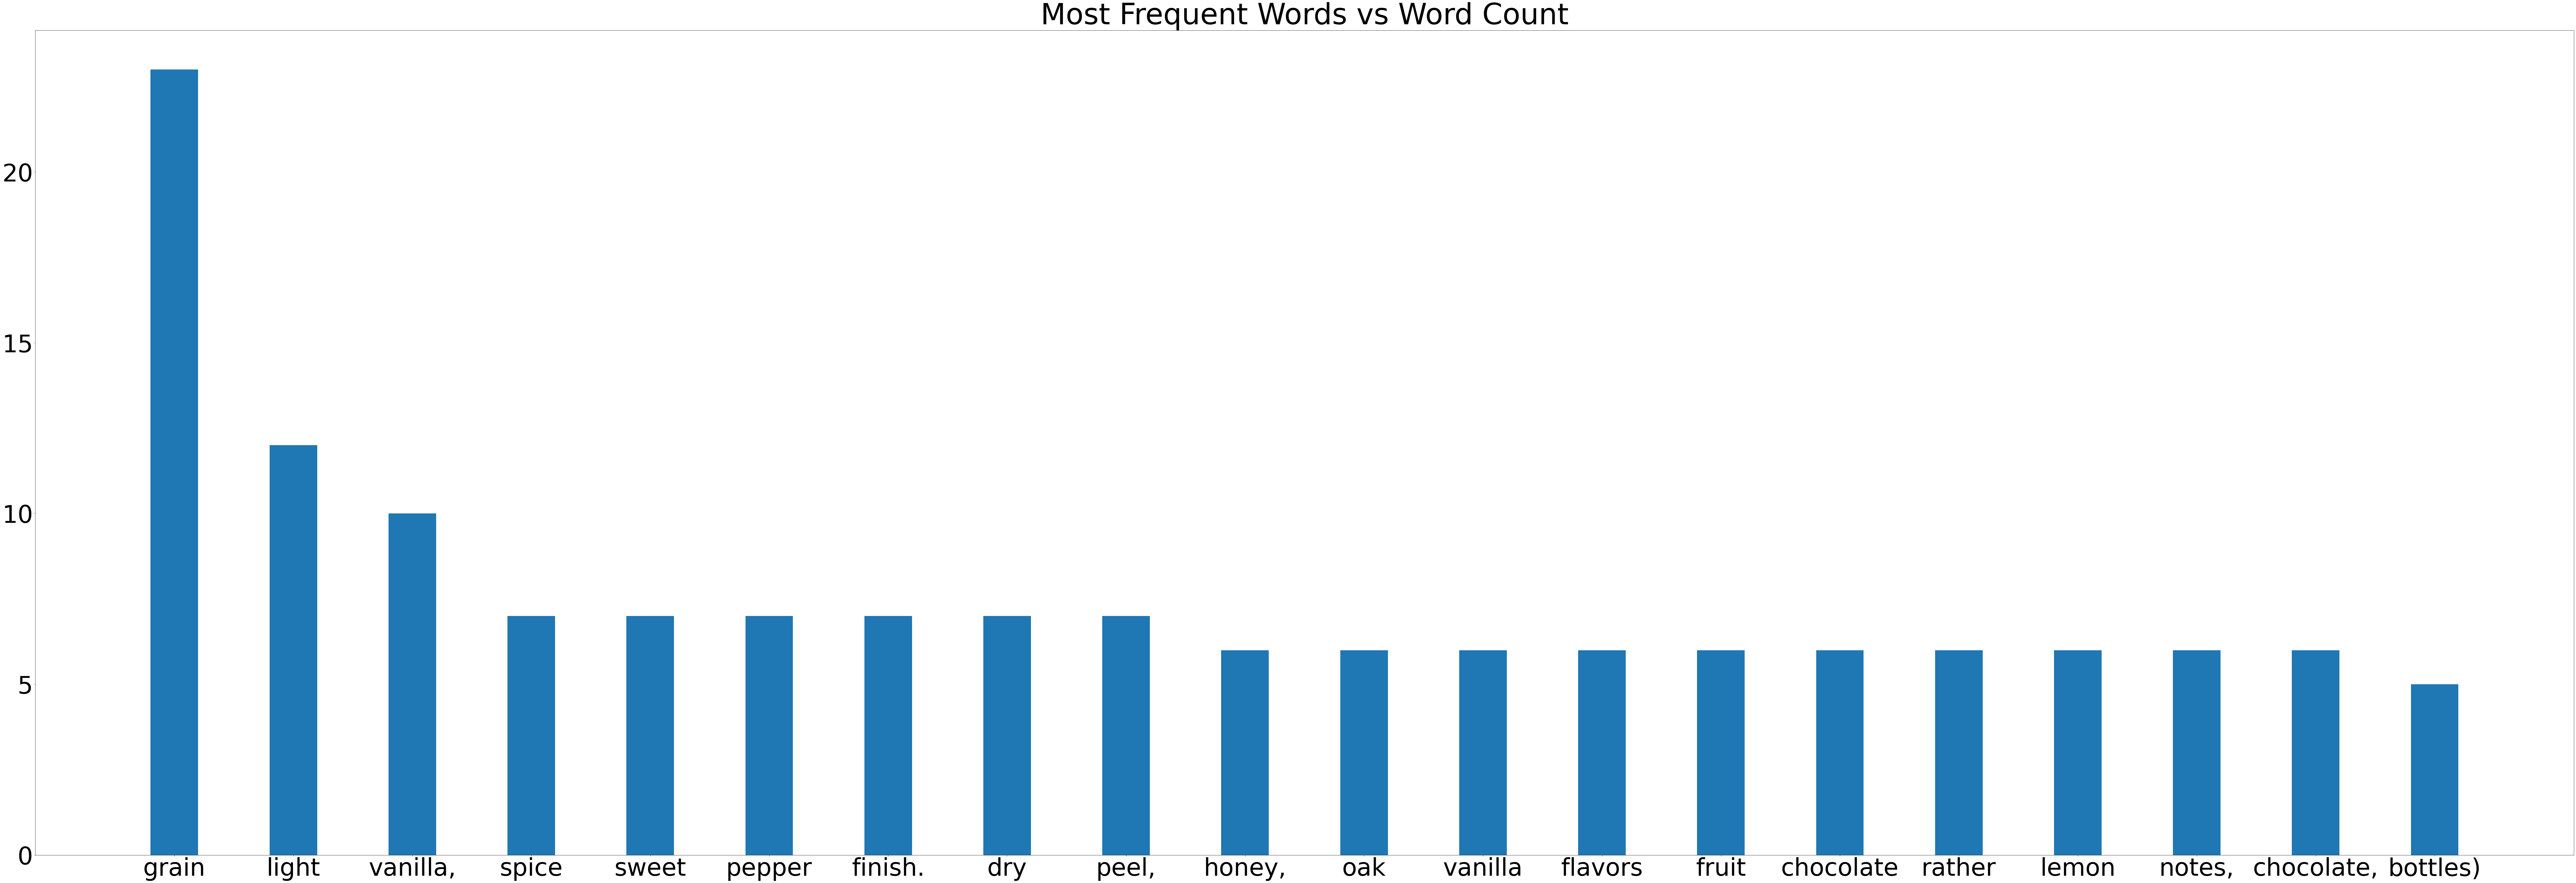

In [102]:
# Write a function to find most frequent words
import collections
stopwords = stop_words
counter=0
Number_of_words=[]
Category=[]
# Find top 10 most frequent words 
wordcount = collections.defaultdict(int)
for word in listToStr.lower().split():
    

    if word not in stopwords:
        wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
plt.rcParams["figure.figsize"] = (150,50)
plt.rcParams.update({'font.size': 80})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent Words vs Word Count")
plt.show()
 

In [103]:
review['count_word']=review["description"].apply(lambda x: len(str(x).split()))
review['count_stopwords']=review['description'].apply(lambda x:len([w for w in str(x).lower().split() if w in stop_words]))

In [104]:
y0 = review[review.category=="Single Malt Scotch"]['count_word'].values
y1 = review[review.category=="Blended Scotch Whisky"]['count_word'].values
y2 = review[review.category=="Blended Malt Scotch Whisky"]['count_word'].values
y3 = review[review.category=="Single Grain Whisky"]['count_word'].values
y4 = review[review.category=="Grain Scotch Whisky"]['count_word'].values
fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Single Malt Scotch',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y1, name = 'Blended Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y2, name = 'Blended Malt Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y3, name = 'Single Grain Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y4, name = 'Grain Scotch Whisky',marker_color = 'royalblue'))
fig.update_layout(
    title_text='Distribution of Words per Sentence per Category', 
    title_x=0.45,
)
fig.show()

In [105]:
y0 = review[review.category=="Single Malt Scotch"]['count_stopwords'].values
y1 = review[review.category=="Blended Scotch Whisky"]['count_stopwords'].values
y2 = review[review.category=="Blended Malt Scotch Whisky"]['count_stopwords'].values
y3 = review[review.category=="Single Grain Whisky"]['count_stopwords'].values
y4 = review[review.category=="Grain Scotch Whisky"]['count_stopwords'].values
fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Single Malt Scotch',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y1, name = 'Blended Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y2, name = 'Blended Malt Scotch Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y3, name = 'Single Grain Whisky',marker_color = 'royalblue'))
fig.add_trace(go.Box(y=y4, name = 'Grain Scotch Whisky',marker_color = 'royalblue'))
fig.update_layout(
    title_text='Distribution of Stopwords per Sentence per Category', 
    title_x=0.45,
)
fig.show()

### Bottle Repeats

In [107]:
# Trying to find the most common brands of whisky
# Counting. bottles, looking for repeats
figure = plt.figure(figsize=(14,12))
dataframe_count=review['name'].value_counts().reset_index(name="Count")[:5]
fig = go.Figure(
    data=[
    go.Bar(x=dataframe_count['index'], y=dataframe_count.Count),
])
fig.update_layout(
    title_text='Bottle Frequency', 
    title_x=0.45,
    xaxis_title="name",
    yaxis_title="count",
)
fig.show() 

<Figure size 1008x864 with 0 Axes>

### 3D Feature Correlation Plot 
#### Price vs Age vs Review Point

This interactively displays how our main features interact with eachother.

In [110]:
fig = px.scatter_3d(review, x='review.point', y='age', z='price')
fig.show()